<a href="https://colab.research.google.com/github/IqbalLx/Data-Science-Project/blob/master/Titanic_Dataset%20-%20EDA_and_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.ensemble import RandomForestClassifier as rfc
import tensorflow as tf

sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Dataset Overview

In [0]:
df = pd.read_csv('titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
df_test = pd.read_csv('titanic_test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [0]:
df.shape

(891, 12)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [0]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [0]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

#Exploratory Data Analysis

In [0]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


Seems that from the descriptive statistics doesn't give much insight, except the std of Age is quite high, it's ranging from 0.42 to 80, so there are any baby passanger, lets check the distribution

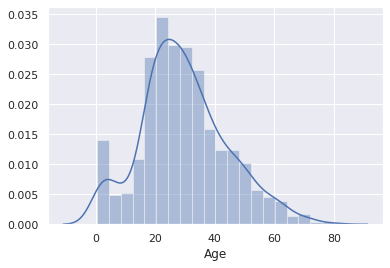

In [0]:
sns.distplot(df.Age)
plt.show()

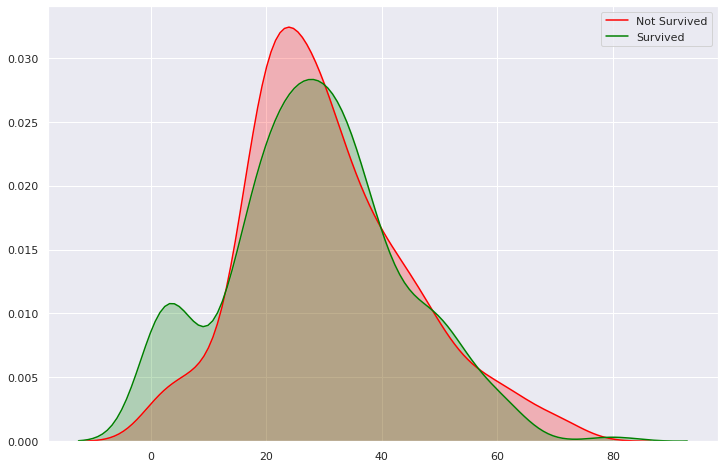

In [0]:
plt.figure(figsize=(12, 8))
sns.kdeplot(df['Age'][df.Survived == 0], label='Not Survived', color='red', shade=True)
sns.kdeplot(df['Age'][df.Survived == 1], label='Survived', color='green', shade=True)
plt.legend()
plt.show()

So the average Age is the most survived, also it's interesting that many Children also survived, maybe the passanger prioritized the kids to be saved first

Pclass is stands for passanger class, lets figure it, is it going to correlated with the passanger survivalness 

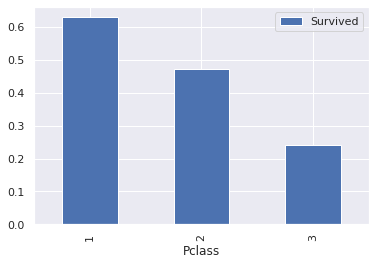

In [0]:
df.groupby('Pclass').agg({'Survived':'mean'}).plot.bar()
plt.show()

Class 1 is tend to survive better

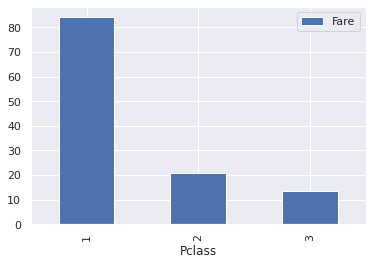

In [0]:
df.groupby('Pclass').agg({'Fare':'mean'}).plot.bar()

Absolutely like I thougt, class 1 is has higher Fare (because I dont know what Fare is, but Google said is Tarif, so class 1 pasti lebih mahal tarifnya, jadi sudah bisa diwakilkan sama column Pclass)

In [0]:
df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

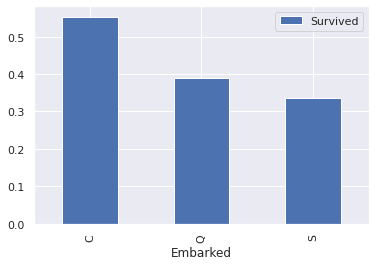

In [0]:
df.groupby('Embarked').agg({'Survived':'mean'}).plot.bar()

I'm not sure if Embarked columns really add value for our model later, because the point of embarkation is not related at all with passanger survivalness. But this chart trying to show us that people from embarkment point C tend to be survive better

#Data Cleaning

In [0]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Dropped columns:
- PassengerId, Ticket, Name = add no information
- Fare = give same info as Pclass
- Cabin = too many missing values

In [0]:
df = df.drop(['PassengerId', 'Ticket', 'Fare', 'Cabin', 'Name'], axis=1)
df_test = df_test.drop(['PassengerId', 'Ticket', 'Fare', 'Cabin', 'Name'], axis=1)

I'm going to fill missing values in Age using its median, because the distribution is right skewed, so it's may cause bias if I fill it with mean

In [0]:
median_age = df.Age.median()
df['Age'].fillna(median_age, inplace=True)
df_test['Age'].fillna(median_age, inplace=True)

Next for missing values in Embarked, I'm going to use its Mode

In [0]:
df['Embarked'].fillna('S', inplace=True)

In [0]:
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Embarked    0
dtype: int64

In [0]:
df_test.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Embarked    0
dtype: int64

Next I wanna deal with categorical data (Embarked and Pclass) using one hot encoding, and Sex by changing male into 1 and 0 for female. For embarked and sex it's needed because model only deal with numbers, and for Pclass since it's nominal type, so 1, 2 and 3 do not mean it's representing order, but just a label

In [0]:
df_embarked_oh = pd.get_dummies(df, columns=['Embarked'])
df_clean = pd.get_dummies(df_embarked_oh, columns=['Pclass'])

df_clean['Sex'] = np.where(df_clean.Sex == 'male', 1, 0)

df_clean.head()

,Survived,Sex,Age,SibSp,Parch,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,1,22.0,1,0,0,0,1,0,0,1
1,1,0,38.0,1,0,1,0,0,1,0,0
2,1,0,26.0,0,0,0,0,1,0,0,1
3,1,0,35.0,1,0,0,0,1,1,0,0
4,0,1,35.0,0,0,0,0,1,0,0,1


In [0]:
df_test_embarked_oh = pd.get_dummies(df_test, columns=['Embarked'])
df_test_clean = pd.get_dummies(df_test_embarked_oh, columns=['Pclass'])

df_test_clean['Sex'] = np.where(df_test.Sex == 'male', 1, 0)

df_test_clean.head()

,Sex,Age,SibSp,Parch,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,34.5,0,0,0,1,0,0,0,1
1,0,47.0,1,0,0,0,1,0,0,1
2,1,62.0,0,0,0,1,0,0,1,0
3,1,27.0,0,0,0,0,1,0,0,1
4,0,22.0,1,1,0,0,1,0,0,1


# Feature Engineering

I wanna add is_alone columns based on SibSp and Parch columns. From kaggle it's representing the family of passanger

In [0]:
df_clean['fams'] = df_clean.SibSp + df_clean.Parch
df_clean['is_alone'] = np.where(df_clean['fams'] > 0, 0, 1)

df_test_clean['fams'] = df_test_clean.SibSp + df_clean.Parch
df_test_clean['is_alone'] = np.where(df_test_clean['fams'] > 0, 0, 1)

In [0]:
df_clean = df_clean.drop(['SibSp', 'Parch', 'fams'], axis=1)
df_test_clean = df_test_clean.drop(['SibSp', 'Parch', 'fams'], axis=1)

df_clean.head()

,Survived,Sex,Age,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,is_alone
0,0,1,22.0,0,0,1,0,0,1,0
1,1,0,38.0,1,0,0,1,0,0,0
2,1,0,26.0,0,0,1,0,0,1,1
3,1,0,35.0,0,0,1,1,0,0,0
4,0,1,35.0,0,0,1,0,0,1,1


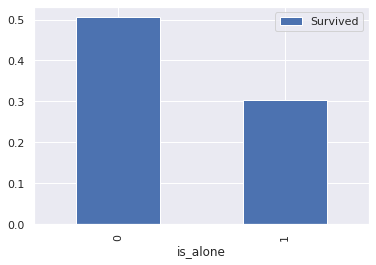

In [0]:
df_clean.groupby('is_alone').agg({'Survived':'mean'}).plot.bar()

Those who travel alone is have less survivalness

# Predictive Modeling

## Build ML Model

In [0]:
X = df_clean.drop(['Survived'], axis=1)
y = df_clean['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

### KNN Classifier

In [0]:
error = []
for i in range(1, 20):
  model = knn(n_neighbors=i)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  error.append(np.mean((y_pred - y_test)**2))

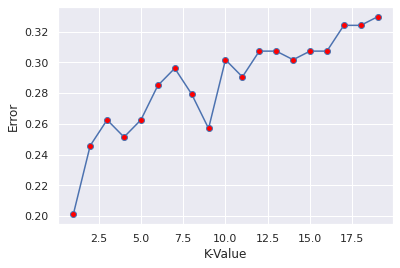

In [0]:
plt.plot(range(1, 20), error, marker='o', markerfacecolor='red')
plt.xlabel('K-Value')
plt.ylabel('Error')
plt.show()

In [0]:
model_knn = knn(n_neighbors=1)
model_knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [0]:
y_pred_knn = model_knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       104
           1       0.77      0.73      0.75        75

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



### Decision Tree Classsifier

In [0]:
model_tree = dtc()
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
y_pred_tree = model_tree.predict(X_test)
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.80      0.88      0.83       104
           1       0.80      0.69      0.74        75

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



### Random Forest Classifier

In [0]:
model_forest = rfc()
model_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
y_pred_forest = model_forest.predict(X_test)
print(classification_report(y_test, y_pred_forest))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       104
           1       0.79      0.75      0.77        75

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



## Build Simple DL Model

In [0]:
model_tf = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(64, activation='relu', input_shape=(len(X_train.columns),)),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model_tf.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['acc']
)

model_tf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 13,249
Trainable params: 13,249
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model_tf.fit(X_train, y_train,
                    epochs=100,
                    validation_split=0.2)

Epoch 1/100
18/18 [==============================] - 0s 11ms/step - loss: 0.7315 - acc: 0.5606 - val_loss: 0.6425 - val_acc: 0.6643
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6918 - acc: 0.5923 - val_loss: 0.6445 - val_acc: 0.6573
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6650 - acc: 0.6380 - val_loss: 0.6177 - val_acc: 0.6573
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6289 - acc: 0.6626 - val_loss: 0.5963 - val_acc: 0.6853
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 0.6175 - acc: 0.6731 - val_loss: 0.5879 - val_acc: 0.6923
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 0.5790 - acc: 0.7188 - val_loss: 0.6058 - val_acc: 0.7063
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 0.5394 - acc: 0.7417 - val_loss: 0.5860 - val_acc: 0.6853
Epoch 8/100
18/18 [==============================] - 0s 3ms/step - loss: 0.5285 - 

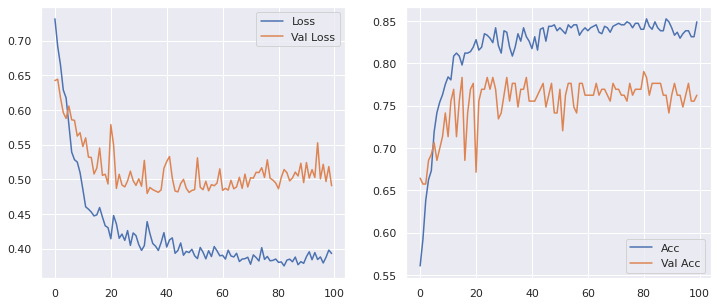

In [0]:
hist = history.history
hist['epoch'] = history.epoch

plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(hist['epoch'], hist['loss'], label='Loss')
plt.plot(hist['epoch'], hist['val_loss'], label='Val Loss')
plt.legend()

plt.subplot(122)
plt.plot(hist['epoch'], hist['acc'], label='Acc')
plt.plot(hist['epoch'], hist['val_acc'], label='Val Acc')
plt.legend()

plt.show()

Overfitting due to too little training data

In [0]:
y_pred_tf = model_tf.predict(X_test)
y_pred_tf = np.where(y_pred_tf > 0.5, 1, 0)
print(classification_report(y_test, y_pred_tf))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86       104
           1       0.86      0.68      0.76        75

    accuracy                           0.82       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.83      0.82      0.82       179



In [0]:
passenger_id = pd.read_csv('titanic_test.csv')['PassengerId']
models = [model_knn, model_tree, model_forest]
name = ['KNN', 'DT', 'RF']

for i, model in enumerate(models):
  y_pred = model.predict(df_test_clean)
  pd_final = pd.DataFrame({
      'PassengerId' : passenger_id,
      'Survived' : y_pred,
  })
  pd_final.to_csv(f'submissions-{name[i]}.csv', index=False)

In [0]:
y_pred_tf_final = model_tf.predict(df_test_clean)
y_pred_tf_final = np.where(y_pred_tf_final >= 0.5, 1, 0)
pd_final = pd.DataFrame({
      'PassengerId' : passenger_id,
      'Survived' : y_pred.reshape(passenger_id.shape[0],),
  })
pd_final.to_csv('submissions-TF.csv', index=False)